In [4]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

### Survey Clean file, creating white/black lists

In [5]:
# Read it in
path = "surveys_clean.csv"
df = pd.read_csv(path, na_filter=False)

# Drop unnecessary columns
df.drop(columns=['ind_id', 'subject_id', 'image_name', 'image_name_2', 'index','outfits','outfits_comment'], inplace=True)

has_data = df['long']!=''
newDF = df[has_data]
newDF.shape

(5404, 2)

In [6]:
whiteDF = newDF[newDF['racial_group'] == 'white']['long']
blackDF = newDF[newDF['racial_group'] == 'black']['long']

whiteList = whiteDF.tolist()
blackList = blackDF.tolist()

In [7]:
whiteList[:5]

['i have no comments.',
 'to maney questions a like in the last here.  the rest alright overseas across',
 "why don't a soldiers have the right to take up any kind of work they want in the army.",
 'good thing if higher authorities get some action on this problems.',
 'some question overlap others and you might think i just checked them to get finished but i checked them as i feel.']

In [8]:
blackDF.head()

0    negro have been told many times they're fighti...
1    i dont like the army. i had rather be on the o...
2    i think that if were going to win this war, th...
3    why is it that the negro dont have the the rig...
4    i highly approve of this questionnaire it give...
Name: long, dtype: object

### DEIM-CUR functions

In [9]:
def cur(A, idx=False, SVD=None, rank=None):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M): # row/column selection
        p = []
        p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(1,rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    p_C = DEIM(np.transpose(Wt))
    C = A[:,p_C]
    
    p_R = DEIM(V)
    R = A[p_R]
    
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    
    return (C,U,R, p_C, p_R) if idx else (C,U,R)

In [10]:
embed_white = (model.encode(whiteList))
embed_black = (model.encode(blackList))

### Top Responses for black respondents 

In [11]:
C_black,U_black,R_black, p_C_black, p_R_black = cur(np.transpose(embed_black), idx=True)

In [12]:
print("Black\n")
for i in range(20):
    print(blackList[p_C_black[i]])

Black

if the negro soldier is good enough to participate in the tough & rough army to help our country why not have privileges as same as the white man. since we are considered rotten & no good, we shouldn't't have to fight. we realize this is a white man's country but we are willing to fight for it because we live in it. therefore after this war i hope every negro will take this matter into consideration and force less segregation & a fair living as white people have. if all negro were like me things would be a hell of a lot better  site worse. we must show the white man we are all men together before we shall have equal rights. a man is a man no matter what race, creed or color, so why not be treated alike.
i think this questionnaire is good for us.
i don't like army in any way
i want to make more money to take care of my wife and get out the army so i can take care of her and my to kids
we don't get much to eat and we can't get attention our doctors when we are sick, the no  office

### Top Responses for white respondents 

In [13]:
 C_white,U_white,R_white, p_C_white, p_R_white = cur(np.transpose(embed_white), idx=True)

In [14]:
print("\nWhite\n")
for i in range(20):
    print(whiteList[p_C_white[i]])


White

in my opinion, the army life is alright. civilians treat us fairly good. i am contented because the boys in our outfit are just like brothers. we all complain as a whole. our officers and men are shifted so much we don't have chance to learn much. men are in our outfit who shouldn't't be here. they only hinder us. to many men kiss asses for their rating, while other, less conservative men who have ability, lose faith in the army and don't give a damn. as a result we have a lot of good men lost in the pile. we have a bunch of gold briggers and ass kissing non-coms, showing off their day old stripes. the officers conduct to many needless inspections, and are shifted around to much to be of any aid to the men under them. only men with brains should run the army. not ones with loud mouths.
i think this questionnaire is a good idea
no comments.
the army is a good place for every man if he is able to be in the army.
i would rather be home i could do more good on relief work.
why all 

## Eigenvalue Graphs (White)

In [15]:
embed = np.transpose(embed_white)
first = pd.DataFrame({'Response': whiteList, 'Embedding': embed_white})
second = pd.DataFrame({'Response': whiteList})

In [16]:
for i in range(0, 768):
    x = []
    for j in range(0, len(embed_white)):
        x.append(first['Embedding'][j][i])
    second['x'+str(i)] = x
    
second.iloc[:,1:]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x758,x759,x760,x761,x762,x763,x764,x765,x766,x767
0,0.758591,0.456631,1.158288,-0.455719,-0.180095,1.283310,0.706048,0.358347,-0.999309,0.344630,...,-0.227195,0.462643,0.086750,-0.168338,-0.294847,-0.733800,-0.064139,1.485314,-0.084078,0.013112
1,0.454678,-0.536229,0.779319,0.193302,-0.092970,-0.065367,-0.889141,-0.867361,-0.364727,-0.262388,...,-0.091493,0.120037,0.284678,0.080229,-0.299972,-0.035708,-0.416625,0.467714,-0.377875,0.374595
2,0.422178,0.610620,-0.317593,0.041234,0.122884,0.505356,1.233452,0.438452,-0.306385,-0.208844,...,-0.180563,0.463026,1.149110,-1.301010,-1.116768,0.115643,-0.163776,0.072889,-0.872556,0.422105
3,-0.170448,-0.680924,1.901574,0.523110,-0.252908,-0.436074,0.231396,-0.113363,-0.252537,-0.799451,...,-0.771372,-0.200827,0.274970,-1.376745,-0.996408,-0.065467,-0.677858,-0.443991,-0.864252,-0.829374
4,0.549441,-0.032283,0.780587,0.240238,-0.428685,-0.063074,0.501355,-0.903985,0.004191,0.049287,...,-0.264759,0.058556,-0.114252,-1.299849,-0.530832,-0.343054,-0.306447,0.633780,-0.793164,0.330236
5,0.004660,-0.301120,0.862109,0.273910,-0.373713,-0.793335,0.772640,0.344798,1.541640,-0.659954,...,0.481832,-0.242059,0.569427,-0.937235,-0.681376,0.322259,-0.742309,-1.169469,0.090096,-0.443329
6,0.799952,0.370300,0.983754,-0.038101,0.426844,-1.270377,0.507401,-1.155068,0.053498,-0.916051,...,-0.162250,-0.737028,0.351942,-0.329651,-0.667495,0.348835,0.448731,0.669346,-0.273538,0.238912
7,-0.467367,1.090383,0.241329,0.144277,-0.339844,0.133298,1.658487,-0.429531,0.158903,-0.426430,...,-0.545814,0.268780,0.433029,-1.372047,-0.123898,-0.303350,-0.207291,0.454587,-0.184143,0.317297
8,0.183044,0.378289,-0.555193,0.195641,-0.400503,-0.059412,0.462276,0.128860,0.248229,-0.508374,...,-0.264521,-0.213790,-0.251426,-0.980537,-0.020352,0.232479,-0.071722,0.376107,0.068536,-0.074467
9,0.025188,0.245247,0.461903,0.159790,-0.337907,-0.568613,1.127125,-0.481804,0.568213,-0.414370,...,-0.470136,0.090522,0.232810,-1.411538,0.170678,-0.009579,0.213635,0.184214,-0.486043,0.871293


In [17]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=second.iloc[:,1:], nn=8)

In [18]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)
np.unique(np.imag(eigenvals))

array([0.])

In [19]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [20]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=1), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 1.4142135625218268
Max Norm: 44.22668877499196


In [21]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

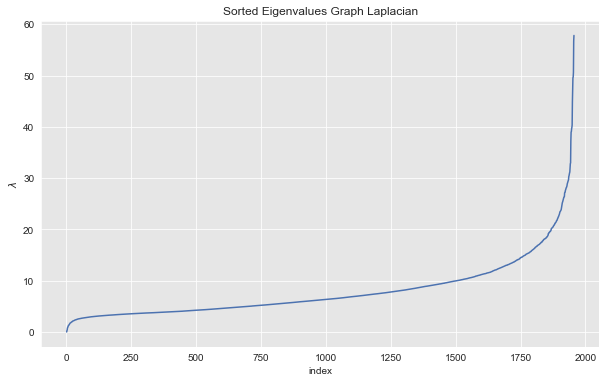

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

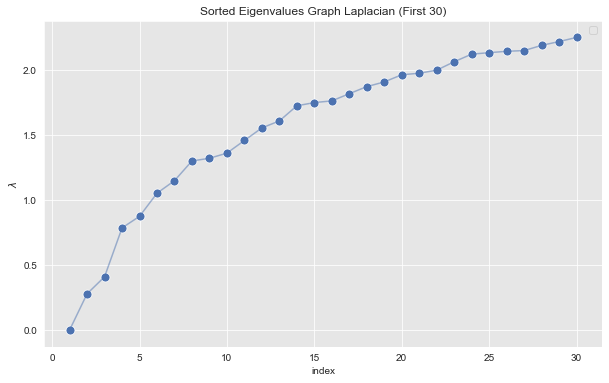

In [23]:
index_lim = 30

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
# ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

## Spectral Clustering on White respondents 

In [24]:
n=3

from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=n,affinity='nearest_neighbors').fit(second.iloc[:, 1:])
first['Cluster'] = [i for i in spectral.labels_]
first['bag'] = first.Response.map(lambda t:t.replace(';','').lower().split())

In [61]:
first.shape

(1956, 3)

In [26]:
whiteClusters = first
whiteClusters.drop(columns=['bag'], inplace=True)
whiteClusters.head()

,Response,Embedding,Cluster
0,i have no comments.,"[0.758591, 0.45663133, 1.1582876, -0.45571896,...",1
1,to maney questions a like in the last here. t...,"[0.4546784, -0.5362293, 0.7793191, 0.19330154,...",0
2,why don't a soldiers have the right to take up...,"[0.42217788, 0.6106196, -0.317593, 0.04123385,...",0
3,good thing if higher authorities get some acti...,"[-0.17044759, -0.6809244, 1.9015743, 0.5231100...",0
4,some question overlap others and you might thi...,"[0.549441, -0.032282595, 0.780587, 0.24023785,...",0


### Method 3 Ranking Functions

In [27]:
def split_responses(responses):
    all_sentences = []
    response_numbers = []
    idx = 0
    for i in responses:
        temp = i.split('. ')
        for k in temp:
            response_numbers.append(idx)
        for j in temp:
            all_sentences.append(j)
        idx += 1
    return all_sentences, response_numbers


In [28]:
def get_index(rankings, responses):
    response_idx = []
    count = 0
    for i in rankings:
        temp = responses[i]
        if temp not in response_idx:
            response_idx.append(temp)
    return response_idx

In [54]:
def DEIM1(M): # row/column selection
        rank = np.linalg.matrix_rank(M)
        p = []
        p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(1,rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p

### Cluster 0 Top Responses

In [30]:
# is_0 = first['Cluster'] == 0
# cluster_0 = first[is_0]

# cluster_0

cluster_0 = [i for i in first['Response'][first['Cluster'] == 0]]


In [31]:
# cluster0List = cluster_0['Response'].tolist()

In [32]:
# embed0 = np.transpose(model.encode(cluster0List))
embed_split_0 = model.encode(split_responses(cluster_0)[0])

In [59]:
U, S, Vt = linalg.svd(embed_split_0, full_matrices = False)

In [60]:
# C_0,U_0,R_0, p_C_0, p_R_0 = cur(embed0, idx=True)
ranking_0 = DEIM1(U)
sentences_0, response_number_0 = split_responses(cluster_0)

In [62]:
[cluster_0[i] for i in get_index(ranking_0, response_number_0)]

["i have been in the air corps three months and so far it has been nothing but a game of politics. to make a rating, a fellow must do practically everything for his non-coms one of which is to keep him furnished with licqor and this is a little difficult to do when a guy doesn't drink himself.  soldiers are not too aware of the fact that we are fighting a war - our men should be more serious minded and i believe things would get along much better in the days to come.",
 'i think the person in charge of the physical education program here at atlantic city is out of his head. i was some what of an athlete before entering the army and considered my self in pretty good shape. instead of being physically outfit the men are being made physical wrecks. the most sleep i have ever gotten in one night is 7 hrs. and i go to bed as soon as i am permitted and as soon as i ready my equipment for the next day which is usually 9:pm 4:30 am we are up. this post is over run with colds & sore throats. th

In [63]:
# print("Cluster 0\n")
# for i in range(5):
#     print(i,':', whiteList[p_C_0[i]],'\n')
ranking_0[0]

3699

In [64]:
sentences_0[3699]

' soldiers are not too aware of the fact that we are fighting a war - our men should be more serious minded and i believe things would get along much better in the days to come.'

In [65]:
ranking_0[1]

5214

In [66]:
sentences_0[5214]

'this is what i attribute it to.'

In [67]:
U.shape

(6206, 768)

In [68]:
len(cluster_0)

1824

### Cluster 1 Top Responses

In [69]:
# is_1 = first['Cluster'] == 1
# cluster_1 = first[is_1]
# cluster1List = cluster_1['Response'].tolist()

cluster_1 = [i for i in first['Response'][first['Cluster'] == 1]]

In [70]:
# embed1 = np.transpose(model.encode(cluster1List))
embed_split_1 = model.encode(split_responses(cluster_1)[0])

In [71]:
# C_1,U_1,R_1, p_C_1, p_R_1 = cur(embed1, idx=True)
U1, S1, Vt1 = linalg.svd(embed_split_1, full_matrices = False)

In [72]:
# print("Cluster 1\n")
# for i in range(5):
#     if(i<len(p_C_1)):
#         print(i,':', whiteList[p_C_1[i]],'\n')

ranking_1 = DEIM1(U1)
sentences_1, response_number_1 = split_responses(cluster_1)

In [73]:
# cluster_1
[cluster_1[i] for i in get_index(ranking_1, response_number_1)]

['none.',
 "sorry i haven't a present",
 '27 because i am small and not very bright',
 'no quistens to be asked',
 'this is nothing to do after retreat no place to go',
 "i don't have any thing to write.",
 'in regard to #27 i feel that i have not been given an opportunity to show my qualifications for a non-comm',
 'i have no comments.',
 'no question except i think this will never be looked at.',
 'i have none.',
 "i don't know any",
 "i haven't any proticualr things to say.",
 'none they answer themselves.',
 'no comment!!!',
 '(no statement)',
 'i have none to make.',
 'no comments made',
 "i don't have any.",
 'no comments.',
 'no comments.',
 'none.',
 'none.',
 'none.']

In [74]:
sentences_1[ranking_1[0]]

'none.'

In [75]:
sentences_1[ranking_1[1]]

"sorry i haven't a present"

### Cluster 2 Top Responses

In [76]:
# is_2 = first['Cluster'] == 2
# cluster_2 = first[is_2]
# cluster2List = cluster_2['Response'].tolist()

cluster_2 = [i for i in first['Response'][first['Cluster'] == 2]]

In [77]:
# embed2 = np.transpose(model.encode(cluster2List))
embed_split_2 = model.encode(split_responses(cluster_2)[0])

In [81]:
# C_2,U_2,R_2, p_C_2, p_R_2 = cur(embed2, idx=True)
U2, S2, Vt2 = linalg.svd(embed_split_2, full_matrices = False)

In [82]:
# print("Cluster 2\n")
# for i in range(5):
#     if(i<len(p_C_2)):
#         print(i,':', whiteList[p_C_2[i]],'\n')

ranking_2 = DEIM1(U2)
sentences_2, response_number_2 = split_responses(cluster_2)

In [83]:
[cluster_2[i] for i in get_index(ranking_2, response_number_2)]

['i think the idea of this questionnaire is very good.',
 'its good',
 'i think i have made all my comments.',
 'no comment from me, a fairly right questionnaire.',
 'this questionnaire is all right. it gives us enlisted men a chance to express our minds.',
 'what  does this help',
 'it was a very interesting set of questions, calling for a little more thinking on my part than i ordinarily do.',
 'it is a very good idea so they know just how the boys feel',
 'i believe this is a very good way of finding out the opinion of all soldiers of what is going on.',
 'this is a good idea to let spec up our own opinion',
 'i think it be enough, and i think we doing for our country i be welcome to do my duties',
 'the questions where fair.',
 'every thing is going just fine with me',
 'i think it is a good thing if the right ones read it',
 'i believe it has been a very good idea, the questionnaire etc. thanks for the opportunity for a frank expression of my opinions.',
 'it is a very good questi

In [84]:
sentences_2[ranking_2[0]]

'i think the idea of this questionnaire is very good.'

In [85]:
sentences_2[ranking_2[1]]

'its good'

## Eigenvalue Graph (Black)

In [86]:
embed = np.transpose(embed_black)
first = pd.DataFrame({'Response': blackList, 'Embedding': embed_black})
second = pd.DataFrame({'Response': blackList})

In [87]:
for i in range(0, 768):
    x = []
    for j in range(0, len(embed_black)):
        x.append(first['Embedding'][j][i])
    second['x'+str(i)] = x
    
second.iloc[:,1:]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x758,x759,x760,x761,x762,x763,x764,x765,x766,x767
0,-0.431953,-0.633117,-0.260997,0.415460,-0.237683,0.366318,0.100023,-0.451081,0.052305,-0.772222,...,-0.642631,0.836087,-0.149190,-1.482470,-0.134439,-0.003614,-0.635169,0.017464,-0.421150,0.702712
1,-0.214992,0.580386,0.443751,0.505816,-0.749663,-0.185046,0.921740,-0.230475,0.477832,-0.794905,...,-0.089814,0.691420,0.742551,-1.448567,-0.545186,0.429773,-0.311271,0.444563,-0.531232,0.895420
2,-0.221185,-0.399868,-0.199939,0.446165,-0.415950,0.128538,0.631262,-0.336796,-0.060227,-0.329619,...,-1.046082,0.840199,-0.032127,-2.288132,-0.212986,0.444507,-0.337037,-0.118294,-0.242437,0.492241
3,-0.295477,0.572017,-0.411632,0.144846,-0.018772,-0.431764,0.487732,-0.857616,-0.205131,-0.364119,...,-0.130924,0.962862,0.074192,-1.474225,0.079387,0.112434,-0.553907,0.097416,-0.755756,0.560328
4,-0.574096,0.517165,0.017152,0.162733,-0.337314,-0.444252,0.936755,-0.192152,0.711736,-0.574696,...,-0.783802,0.350003,-0.138772,-2.146735,-0.595041,-0.228926,0.669961,0.770852,0.078583,0.114617
5,-0.129600,-0.261325,0.835405,0.506072,0.061220,-0.294037,0.120656,-0.810101,0.435580,-1.011258,...,-0.442945,0.436407,-0.291818,-0.086346,0.090718,-0.196374,-0.844386,-0.142229,-0.793373,0.124300
6,0.705506,0.260656,1.377129,-0.589358,-0.328145,-0.258725,-0.291662,0.063210,-0.334792,-0.747061,...,-0.579069,-0.448920,0.896083,0.289612,-0.295455,0.477540,-0.395083,1.179413,0.365323,0.002767
7,-0.100324,0.106731,-0.172789,-0.011465,0.139848,-0.310977,0.551033,-0.638847,0.252459,-0.805329,...,-0.678320,-0.223613,-1.558329,-1.466871,0.271727,-0.165487,-0.295605,0.819695,-0.286685,0.278997
8,-0.162554,0.039374,0.028283,0.265046,0.288264,0.369567,0.081332,-0.402532,-0.118626,-0.996127,...,-0.384398,0.380285,0.070555,-0.870803,0.246333,-0.137658,-0.602829,0.167117,-0.568393,0.324509
9,0.535083,0.356359,1.297027,-0.067209,0.407620,-0.337240,0.114972,-0.310488,0.436291,0.049877,...,-0.105883,-0.432709,0.637354,-0.878139,-0.101677,0.152479,-0.498487,0.130223,-0.645121,0.334355


In [88]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=second.iloc[:,1:], nn=8)

In [89]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)
np.unique(np.imag(eigenvals))

array([0.])

In [90]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [91]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=1), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 2.5463820878214065
Max Norm: 58.7196730236128


In [92]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

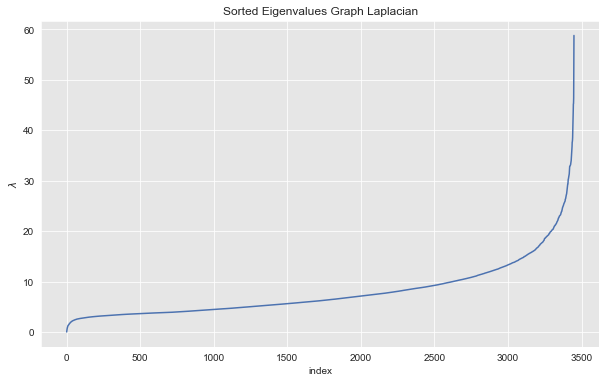

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

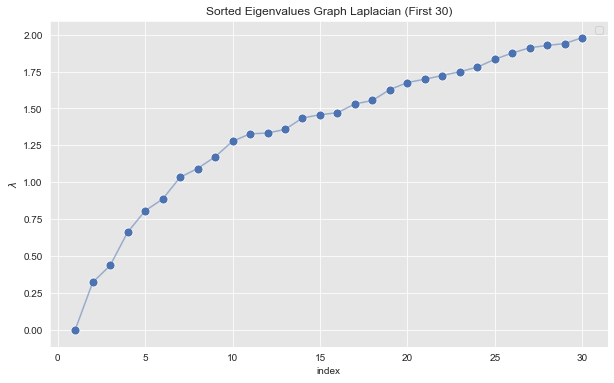

In [94]:
index_lim = 30

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
# ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

### Spectral Clustering on Black Respondents

In [114]:
n=6
spectral = SpectralClustering(n_clusters=n,affinity='nearest_neighbors').fit(second.iloc[:, 1:])
first['Cluster'] = [i for i in spectral.labels_]
first['bag'] = first.Response.map(lambda t:t.replace(';','').lower().split())

In [115]:
first.head()

,Response,Embedding,Cluster,bag
0,negro have been told many times they're fighti...,"[-0.43195295, -0.6331174, -0.26099682, 0.41546...",1,"[negro, have, been, told, many, times, they're..."
1,i dont like the army. i had rather be on the o...,"[-0.21499196, 0.58038604, 0.44375092, 0.505815...",1,"[i, dont, like, the, army., i, had, rather, be..."
2,"i think that if were going to win this war, th...","[-0.22118457, -0.39986774, -0.19993901, 0.4461...",1,"[i, think, that, if, were, going, to, win, thi..."
3,why is it that the negro dont have the the rig...,"[-0.29547727, 0.57201684, -0.41163206, 0.14484...",1,"[why, is, it, that, the, negro, dont, have, th..."
4,i highly approve of this questionnaire it give...,"[-0.57409626, 0.5171654, 0.01715225, 0.1627326...",1,"[i, highly, approve, of, this, questionnaire, ..."


In [116]:
blackClusters = first
blackClusters.drop(columns=['bag'], inplace=True)
blackClusters.head()

,Response,Embedding,Cluster
0,negro have been told many times they're fighti...,"[-0.43195295, -0.6331174, -0.26099682, 0.41546...",1
1,i dont like the army. i had rather be on the o...,"[-0.21499196, 0.58038604, 0.44375092, 0.505815...",1
2,"i think that if were going to win this war, th...","[-0.22118457, -0.39986774, -0.19993901, 0.4461...",1
3,why is it that the negro dont have the the rig...,"[-0.29547727, 0.57201684, -0.41163206, 0.14484...",1
4,i highly approve of this questionnaire it give...,"[-0.57409626, 0.5171654, 0.01715225, 0.1627326...",1


### Cluster 0 Top Responses (Black)

In [117]:
# is_0 = first['Cluster'] == 0
# cluster_0 = first[is_0]
# cluster0List = cluster_0['Response'].tolist()

In [118]:
# cluster_0.shape

In [119]:
# embed0 = np.transpose(model.encode(cluster0List))

In [120]:
# C_0,U_0,R_0, p_C_0, p_R_0 = cur(embed0, idx=True)

In [121]:
# print("Cluster 0\n")
# for i in range(5):
#     if(i<len(p_C_0)):
#         print(i,':', blackList[p_C_0[i]],'\n')

In [122]:
cluster_0 = [i for i in first['Response'][first['Cluster'] == 0]]

In [123]:
len(cluster_0)

989

In [124]:
embed_split_0 = model.encode(split_responses(cluster_0)[0])
U0, S0, Vt0 = linalg.svd(embed_split_0, full_matrices = False)
ranking_0 = DEIM1(U0)
sentences_0, response_number_0 = split_responses(cluster_0)
[cluster_0[i] for i in get_index(ranking_0, response_number_0)][:20]

['i like the camp where i am at but i dont like infantry. i would like to be in quarter-master. i would seccused much better that is my idea.',
 "i will be glad when the war is over i have been in the army nine months an  had a furlough. i'll be happy to get on. i wish they would change the cooks in co. c. 827.",
 "the camps are really filled with men that could do more for the country by working in defense plants than they can as a soldier. i will be forty 41 yrs old next month and feel  three months in the army than i have a year ago. after i get through drilling i am through tired and sore to the bone. all recreation and service clubs in the south should be separate. thanks to new york camp upton you can go any way eat any way no trouble but down here that's not. i would really like to be out of this berg before i go nuts. this place is no good. camp shelly miss",
 'no 31 have not never been train never have shot a gun sense i been in the army  8 under decide  no 21  i could make go

In [125]:
sentences_0[ranking_0[0]]

'i like the camp where i am at but i dont like infantry'

In [126]:
sentences_0[ranking_0[1]]

"i'll be happy to get on"

### Cluster 1 Top Responses (Black)

In [128]:
# is_1 = first['Cluster'] == 1
# cluster_1 = first[is_1]
# cluster1List = cluster_1['Response'].tolist()

In [129]:
# embed1 = np.transpose(model.encode(cluster1List))

# C_1,U_1,R_1, p_C_1, p_R_1 = cur(embed1, idx=True)

# print("Cluster 1\n")
# for i in range(5):
#     if(i<len(p_C_1)):
#         print(i,':', blackList[p_C_1[i]],'\n')

In [130]:
cluster_1 = [i for i in first['Response'][first['Cluster'] == 1]]

In [131]:
len(cluster_1)

1863

In [132]:
embed_split_1 = model.encode(split_responses(cluster_1)[0])
U1, S1, Vt1 = linalg.svd(embed_split_1, full_matrices = False)
ranking_1 = DEIM1(U1)
sentences_1, response_number_1 = split_responses(cluster_1)

["the part the negro plays in this war will have a great deal of bearing on his future, if the negro shows just what he is capable of doing and that he plays an important part in this war the white man will realize that with out him they would be last after the war the negro will have already shown that he is competent in all class. he then should be given the  respect and rights do him, the  realize they are not getting the rights they deserve, after the war  the us wins and the negro recieves his just rights this will be a far better country. then the two classes will have respect for each. the negro is fighting two fights, one here and one on foreign soil. he has surpassed the average white man's",
 'this war is to insure for various minorities the protection of their right & privileges that should be theirs in a democractic state. yet the u.s have made very little efforts to grant the negro those rights that the constitution says should be his. why do i as a negro wear the uniform 

In [133]:
sentences_1[ranking_1[0]]

'he then should be given the  respect and rights do him, the  realize they are not getting the rights they deserve, after the war  the us wins and the negro recieves his just rights this will be a far better country'

In [134]:
sentences_1[ranking_1[1]]

'the same conditions exists'

### Cluster 2 Top Responses (Black)

In [135]:
# is_2 = first['Cluster'] == 2
# cluster_2 = first[is_2]
# cluster2List = cluster_2['Response'].tolist()

In [136]:
# embed2 = np.transpose(model.encode(cluster2List))

#C_2,U_2,R_2, p_C_2, p_R_2 = cur(embed2, idx=True)

# print("Cluster 2\n")
# for i in range(5):
#     if(i<len(p_C_2)):
#         print(i,':', blackList[p_C_2[i]],'\n')

In [137]:
cluster_2 = [i for i in first['Response'][first['Cluster'] == 2]]

In [138]:
len(cluster_2)

107

In [139]:
embed_split_2 = model.encode(split_responses(cluster_2)[0])
U2, S2, Vt2 = linalg.svd(embed_split_2, full_matrices = False)
ranking_2 = DEIM1(U2)
sentences_2, response_number_2 = split_responses(cluster_2)
[cluster_2[i] for i in get_index(ranking_2, response_number_2)]

['i think it is good',
 'this questionnaire is pretty good about the questions it asks.',
 'there are no comments; all is okay.',
 'i do hope this will serve the purpose. i have given my utmost opinion, expressing my feelings.',
 'i think it is well completed',
 "it's fair - only about fair",
 'as a whole the questionnaires are very fine. it helps us a lot and it gives us something to think about. as a whole, the questionnaire are very fine it help us a lots and it give us something to think about.',
 'i think this is a good test i hope that it can be some use.',
 "questions are a little too suttle. in the main general idea it's good. the bare act of expression opinion of a certain value of course - whether or not opinion is requarded",
 'i have no comment what so ever to make. everything seems all right to me.',
 'this is one of the finest ideas one could ever think of on the contrary.',
 'think it is well covered. glad to have chance to express my opinion',
 'i thank the ',
 '56. a f

In [140]:
sentences_2[ranking_2[0]]

'i think it is good'

In [141]:
sentences_2[ranking_2[1]]

'this questionnaire is pretty good about the questions it asks.'

### Cluster 3 Top Responses (Black)

In [143]:
cluster_3 = [i for i in first['Response'][first['Cluster'] == 3]]

In [145]:
len(cluster_3)

203

In [146]:
embed_split_3 = model.encode(split_responses(cluster_3)[0])
U3, S3, Vt3 = linalg.svd(embed_split_3, full_matrices = False)
ranking_3 = DEIM1(U3)
sentences_3, response_number_3 = split_responses(cluster_3)
[cluster_3[i] for i in get_index(ranking_3, response_number_3)][:20]

["discrimination in the south among white and negro soldiers is intolerable. -- the bus service  to and from our post is extremely poor, it is run by a southern white concern who seemingly have no regards for its soldier passengers. the civilians in this locality are hostile toward the soldiers. they act as though we are not offering our very life's blood for their welfare as much as ours. the mp's on the post are very unfair toward the soldier. instead of protecting him, they are against him in almost every instant. they are no protection whatsoever to the soldier in town. instead of protecting him against the civilian , they  blank on him and take advantage of him. instead of carrying a gun in town to protect his fellow soldier, he carries a night stick which he uses freely on the heads of his fellow soldier at the slightest provocation, but he carries a pistol on the post -- a place where it is not needed. there is no place in the army for cliques, the man with ability should lead, 

In [147]:
sentences_3[ranking_3[0]]

'-- the bus service  to and from our post is extremely poor, it is run by a southern white concern who seemingly have no regards for its soldier passengers'

In [148]:
sentences_3[ranking_3[1]]

'and in the same uniform.'

### Cluster 4 Top Responses (Black)

In [152]:
cluster_4 = [i for i in first['Response'][first['Cluster'] == 4]]

In [153]:
len(cluster_4)

260

In [154]:
embed_split_4 = model.encode(split_responses(cluster_4)[0])
U4, S4, Vt4 = linalg.svd(embed_split_4, full_matrices = False)
ranking_4 = DEIM1(U4)
sentences_4, response_number_4 = split_responses(cluster_4)
[cluster_4[i] for i in get_index(ranking_4, response_number_4)][:20]

['this questionnaire is a very well constructed and informative one. informative in this respect, after reading it one can or should be able to see what is most needed to improve unity, understanding, brotherly love and such other elements that make up a true, freedom loving people the world over.',
 'i like for every soldier in the army to get the analysis of these questionnaires so that they will know how the others are thinking.',
 'i like the army fine and have a very nice time and have very fine officers we are treated very nice and have a fine group of soldiers',
 'all questions were very individual and i hope you will agree with me and dont for get give me fort dix, n.j. i do my job every day.',
 'i really would like to know what all of these questions consist of. i hope i soon find out.',
 'the army is o.k. with me',
 "as far as i understand, i don't have any complaint about this. we should do right, do our share, and be kind to each other. be friendly and share together. treat

In [155]:
sentences_4[ranking_4[0]]

'this questionnaire is a very well constructed and informative one'

In [156]:
sentences_4[ranking_4[1]]

'i like for every soldier in the army to get the analysis of these questionnaires so that they will know how the others are thinking.'

### Cluster 5 Top Responses (Black)

In [157]:
cluster_5 = [i for i in first['Response'][first['Cluster'] == 5]]

In [158]:
len(cluster_5)

26

In [159]:
embed_split_5 = model.encode(split_responses(cluster_5)[0])
U5, S5, Vt5 = linalg.svd(embed_split_5, full_matrices = False)
ranking_5 = DEIM1(U5)
sentences_5, response_number_5 = split_responses(cluster_5)
[cluster_5[i] for i in get_index(ranking_5, response_number_5)][:20]

["i don't have any comments to give. i don‚äôt have any comments to give.",
 "i am to far to . i can't walk very far",
 'i dont wish to write anything i have said all i have to say',
 'it not what it ought to be',
 'prectly all none comes gets their comision from tolling',
 'not any more. not any more',
 'i dont has sorry',
 'does not have any other comments about this questionnaire',
 "i haven't anything to say i don't reckon what to say",
 'i dont have any other questions.',
 "don't have any commince",
 'i have none',
 'i have not any more ',
 "i don't have any thing to say about it all.",
 'no comments about this questionnaire what so ever.',
 'i dont have i am thing to say about it.',
 'i have no comments to make about questionnaire.',
 "i don't wish to make any comments.",
 'dont have one',
 'i have no comments what so ever to make.']

In [160]:
sentences_5[ranking_5[0]]

"i don't have any comments to give"

In [161]:
sentences_5[ranking_5[1]]

'i am to far to '